<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-new-score" data-toc-modified-id="Create-new-score-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create new score</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Confusion matrix</a></span></li><li><span><a href="#Scatter-plot" data-toc-modified-id="Scatter-plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scatter plot</a></span></li><li><span><a href="#Details-on-each-problematic-classifications" data-toc-modified-id="Details-on-each-problematic-classifications-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Details on each problematic classifications</a></span><ul class="toc-item"><li><span><a href="#Ambiguous-classification" data-toc-modified-id="Ambiguous-classification-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Ambiguous classification</a></span></li><li><span><a href="#'Some'-category" data-toc-modified-id="'Some'-category-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>'Some' category</a></span></li><li><span><a href="#insufficient-evidence" data-toc-modified-id="insufficient-evidence-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>insufficient evidence</a></span></li><li><span><a href="#Wrongly-classified-jobs" data-toc-modified-id="Wrongly-classified-jobs-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Wrongly classified jobs</a></span><ul class="toc-item"><li><span><a href="#Description-of-the-wrongly-classify-as-Software-job" data-toc-modified-id="Description-of-the-wrongly-classify-as-Software-job-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Description of the wrongly classify as Software job</a></span></li><li><span><a href="#Description-of-the-wrongly-classify-as-NOT-Software-job" data-toc-modified-id="Description-of-the-wrongly-classify-as-NOT-Software-job-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>Description of the wrongly classify as NOT Software job</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import re
import glob
import itertools
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

In [2]:
data = pd.read_csv('data/model_data_test.csv')
data = data.drop('Unnamed: 0', axis=1)

In [3]:
df = data['tags'].str.replace("'", "").str.replace(']', '').str.replace('[', '').str.replace(' ', '').str.split(',', expand=True)
df.columns = ['tags_1', 'tags_2', 'tags_3']
training = pd.concat([data, df], axis=1, sort=False)
training.drop('tags', axis=1, inplace=True)
# The prediction are in the way to predict if the job is a NOT software job. Inverse the score to make it easier to read
training['prediction_proba'] = training['prediction_proba'].apply(lambda x: 1-x)
len(training)

260

## Create new score

In [4]:
def calculate_score(row):
    """
    This function aggregate the different tags given by people to a job ads into an integrate one, computed with the
    mean and some other calculation to reflect the different possibilities given.
    The different possibilities were:
        1. Insufficient evidence: no enough information to see if the jobs ads requires software development or not
        2. None: no software development required
        3. Some: some software development required
        4. Most: mainly software development
    For the rest it transform the different category into numerical value
        . None: 0
        . Some: 1
        . Most: 2
    From there, the mean is calculated. and from the result the three category are recreated
        . [0, 0.33, 0.5]: None
        . [0.6, 1]: Some
        . > 1: Most
    If there is one insufficient information among the tags, it negative the mean. If there is a consensus of Insufficient
    Information it gives a -10
    
    :params:
        df: containing the columns to compute
    :return:
        a panda Series with the computated mean
    """
    list_values = list()
    insufficient = 0
    for r in row:
        if r == 'No':
            list_values.append(0)
        elif r == 'Some':
            list_values.append(1)
        elif r == 'Most':
            list_values.append(2)
        elif r == 'InsufficientEvidence':
            insufficient +=1
        else:
            pass
    if insufficient > 1:
        return -10
    elif insufficient == 1:
        if len(list_values) == 1:
            return -0
        else:
            return (-(sum(list_values) / float(len(list_values))))/2
    else:
        if len(list_values) == 1:
            return 0
        else:
            return (sum(list_values) / float(len(list_values)))/2

In [5]:
training['agg_tag'] = df.loc[:, ['tags_1', 'tags_2', 'tags_3']].apply(calculate_score, axis=1)
training['agg_tag'].value_counts()

 0.000000     159
 0.166667      22
 0.500000      16
 0.750000      15
 0.333333      12
 1.000000      12
-0.500000       8
-0.250000       7
-10.000000      5
-1.000000       2
 0.250000       1
-0.750000       1
Name: agg_tag, dtype: int64

In [6]:
training['created_tag'] = training['agg_tag'].apply(lambda x: 1 if abs(x)>=.5 and abs(x) < 10 else 0)
training['corresponding_tag'] = np.where(training['created_tag'] == training['prediction'], True, False)

In [7]:
#training[['run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

## Confusion matrix

In [8]:
training.groupby('prediction')['corresponding_tag'].value_counts()

prediction  corresponding_tag
0           True                 195
            False                  7
1           True                  47
            False                 11
Name: corresponding_tag, dtype: int64

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [10]:
y_test = training['created_tag']
y_pred = training['prediction']

In [11]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = ['Not Research Software Job', 'Research Software Job']

Confusion matrix, without normalization
[[195  11]
 [  7  47]]


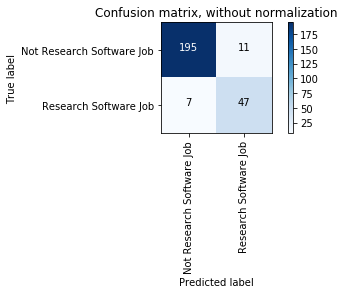

Normalized confusion matrix
[[0.95 0.05]
 [0.13 0.87]]


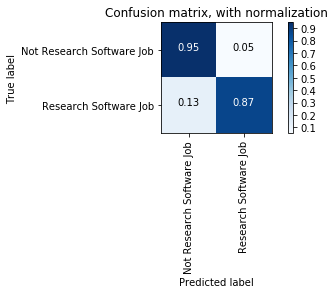

In [12]:
plt.figure()
plot = plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization', normalize=False)
plt.show();

plt.figure()
plot = plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, with normalization', normalize=True)
plt.show();
#plt.savefig('../outputs/dataPrediction/confusion_matrix_normalised.png', dpi=300, bbox_inches='tight')

## Scatter plot

In [13]:
def color_right(x, y):
    col = list()
    for i, j in zip(x, y):
        if i < 0.33 and j < 0.5:
            col.append('g')
        elif i < 0.33 and j > 0.5:
            col.append('r')
        elif i > 0.5 and j > 0.5:
            col.append('g')
        elif i > 0.5 and j < 0.5:
            col.append('r')
        elif i == 0.5:
            col.append('grey')
        else:
            col.append('darkorange')
    return col

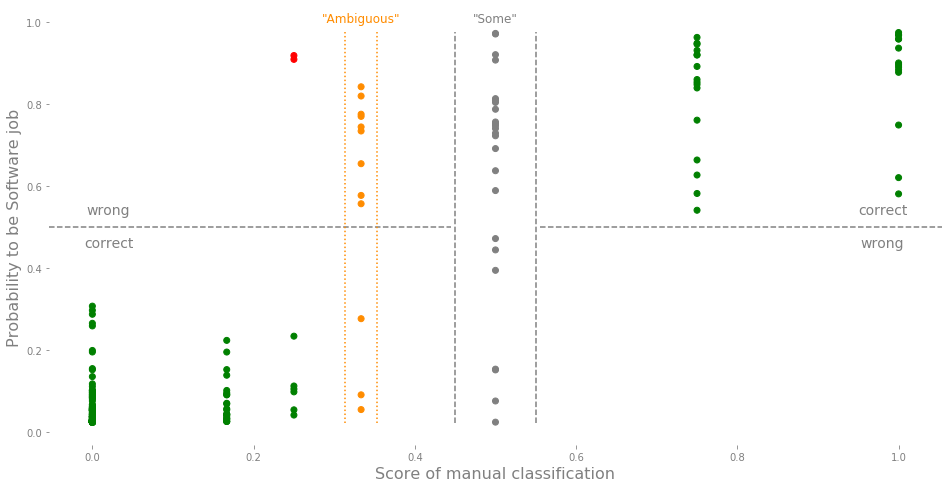

In [14]:
# Get a scatter plot to see the relation between the agg_tag score and the prediction proba to see where the model failed
# It seems to performing relatively according to expectation. There is a confusing point when aggregate score == 1
# and when the aggregate score is between 0.5 and 0.75 where it appears to classify it as in the opposite direction
# These score seems to represent ambiguious score where people have opposite views on the jobs ads. 

tag_creat = [abs(x) for x in training['agg_tag'] if abs(x) < 10]
pred_inv = [x for x in  training[training['agg_tag'] > -10]['prediction_proba']]

col = color_right(tag_creat, pred_inv)

fig, ax = plt.subplots(figsize=(16, 8))

plt.axhline(y=0.5, xmax=0.45, color='grey', linestyle='--')
plt.axvline(x=0.45, ymin=0.05, ymax=0.95, color='grey', linestyle='--')

plt.axhline(y=0.5, xmin=0.55, color='grey', linestyle='--')
plt.axvline(x=0.55,ymin=0.05, ymax=0.95, color='grey', linestyle='--')

plt.axvline(x=0.31333, ymin=0.05, ymax=0.95, color='darkorange', linestyle=':')
plt.axvline(x=0.35333,ymin=0.05, ymax=0.95, color='darkorange', linestyle=':')
plt.text(0.3333,1,'"Ambiguous"', color='darkorange', fontsize=12, horizontalalignment='center')

plt.text(0.5,1,'"Some"', color='grey', fontsize=12, horizontalalignment='center')

plt.text(0.98,0.53,'correct', color='grey',fontsize=14, horizontalalignment='center')
plt.text(0.02,0.45,'correct', color='grey',fontsize=14, horizontalalignment='center')
plt.text(0.98,0.45,'wrong', color='grey', fontsize=14, horizontalalignment='center')
plt.text(0.02,0.53,'wrong', color='grey', fontsize=14, horizontalalignment='center')

ax.set_ylabel('Probability to be Software job', fontsize=16, color='grey')
ax.tick_params(axis='y', colors='grey')

ax.set_xlabel('Score of manual classification', fontsize=16, color='grey')
ax.tick_params(axis='x', colors='grey')

plt.scatter(tag_creat, pred_inv, color=col)

#ax.xlabel('Score of manual classification', fontsize=14, color='grey')
for d in ["left", "top", "bottom", "right"]:
    plt.gca().spines[d].set_visible(False)


## Details on each problematic classifications

 ### Ambiguous classification

In [15]:
training[(training['agg_tag'] > 0.3) & (training['agg_tag'] < 0.4)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag
29,AJJ541,first_run,Some,Some,No,0.333333,0,1,0.774545,False
39,AJR085,first_run,Some,No,Some,0.333333,0,1,0.841471,False
58,AKC175,first_run,No,No,Most,0.333333,0,0,0.090118,True
67,AKI397,first_run,Some,Some,No,0.333333,0,1,0.818867,False
106,ALD850,first_run,No,Some,Some,0.333333,0,1,0.653838,False
159,AMI367,first_run,No,Some,Some,0.333333,0,1,0.556134,False
171,AMN906,first_run,No,No,Most,0.333333,0,0,0.275831,True
184,AMX585,first_run,Some,No,Some,0.333333,0,1,0.733577,False
187,AMZ242,first_run,Some,No,Some,0.333333,0,1,0.769226,False
194,ANG993,first_run,Some,No,Some,0.333333,0,1,0.743519,False


### 'Some' category

In [16]:
training[(abs(training['agg_tag']) ==0.5)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag
13,AJE987,first_run,No,InsufficientEvidence,Most,-0.5,1,0,0.150855,False
17,AJF652,first_run,Some,Some,None,0.5,1,1,0.588299,True
19,AJH016,first_run,No,Most,InsufficientEvidence,-0.5,1,0,0.393727,False
23,AJI375,first_run,Some,Some,None,0.5,1,1,0.751355,True
26,AJJ046,first_run,InsufficientEvidence,Some,Some,-0.5,1,1,0.803341,True
27,AJJ266,first_run,Most,No,Some,0.5,1,1,0.970134,True
31,AJM416,first_run,InsufficientEvidence,No,Most,-0.5,1,1,0.690741,True
37,AJP432,first_run,Some,Some,None,0.5,1,1,0.739693,True
46,AJX808,first_run,InsufficientEvidence,Most,No,-0.5,1,0,0.152786,False
48,AJY559,first_run,InsufficientEvidence,Some,Some,-0.5,1,1,0.721914,True


### insufficient evidence

In [17]:
training[(training['agg_tag'] <0)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag
13,AJE987,first_run,No,InsufficientEvidence,Most,-0.50,1,0,0.150855,False
18,AJG800,first_run,InsufficientEvidence,InsufficientEvidence,None,-10.00,0,0,0.190167,True
19,AJH016,first_run,No,Most,InsufficientEvidence,-0.50,1,0,0.393727,False
25,AJI975,first_run,Most,InsufficientEvidence,InsufficientEvidence,-10.00,0,0,0.049979,True
26,AJJ046,first_run,InsufficientEvidence,Some,Some,-0.50,1,1,0.803341,True
31,AJM416,first_run,InsufficientEvidence,No,Most,-0.50,1,1,0.690741,True
32,AJM565,first_run,InsufficientEvidence,No,Some,-0.25,0,0,0.040731,True
46,AJX808,first_run,InsufficientEvidence,Most,No,-0.50,1,0,0.152786,False
48,AJY559,first_run,InsufficientEvidence,Some,Some,-0.50,1,1,0.721914,True
51,AJY914,first_run,Most,Some,InsufficientEvidence,-0.75,1,1,0.852623,True


### Wrongly classified jobs

#### Description of the wrongly classify as Software job

In [18]:
training[(abs(training['agg_tag']) < 0.33) &(training['prediction_proba'] > 0.5)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag
131,ALR295,first_run,Some,No,InsufficientEvidence,-0.25,0,1,0.917666,False
136,ALS409,first_run,Some,InsufficientEvidence,No,-0.25,0,1,0.908283,False


In [19]:
wrong_soft = training[(abs(training['agg_tag']) < 0.33) &(training['prediction_proba'] > 0.5)]['description']
for i in wrong_soft:
    print(i)


 The Department of Aeronautics wishes to make an academic appointment in the area of Aerospace Engineering.  We expect the successful candidate to be an enthusiastic teacher and outstanding researcher who will help maintain our high levels of scholarship and research.  In the recent REF 2014 exercise, 46% of the department’s research was defined as “world leading”. 
 The department is very active in a range of research aimed at developing and applying theoretical, computational and experimental techniques to address the most challenging, fundamental problems in Aeronautics science and technology with the aim of reducing emission, noise and weight of next generation of aircraft.  Recently, the department has initiated the establishment of a research network within the College focused on the theme of Green Aviation. The department is now intending to further grow its expertise in space research. 
 The successful applicant will have a strong research reputation in one or more of the foll

#### Description of the wrongly classify as NOT Software job

In [20]:
training[(abs(training['agg_tag']) > 0.5) & (abs(training['agg_tag']) < 10) &(training['prediction_proba'] < 0.5)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag


In [21]:
wrong_not = training[(abs(training['agg_tag']) > 0.5) & (abs(training['agg_tag']) < 10) &(training['prediction_proba'] < 0.5)]['description']
for i in wrong_not:
    print(i)